In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from scipy.integrate import quad
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
# since the authors dont provide raw data (please use e.g. zenodo) then I "digitized" their images
df = pd.read_csv("wpd_datasets.csv", header=[0,1])

In [3]:
df.head()

m6T                   noActrl                       m6A  \
            X             Y           X             Y           X   
0    0.633532  3.282137e+05    0.220733  3.033948e+05    0.222007   
1   48.025188  1.622008e+06   48.017544  1.473401e+06   48.017544   
2   96.363480  5.318397e+06   96.357110  5.194557e+06   96.772457   
3  143.736025  6.240672e+06  143.732203  6.166368e+06  144.957860   
4         NaN           NaN         NaN           NaN         NaN   

                titnoActrl               m6Ttit               titm6A  \
              Y          X         Y          X         Y          X   
0  3.281627e+05  35.016454  0.704225  47.996191  0.824950  62.009193   
1  1.473401e+06  35.811942  4.205231  48.798209  2.877264  60.384482   
2  5.268912e+06  34.185598  5.050302  47.174041  3.239437  62.001032   
3  5.993145e+06  34.994689  5.533199  49.045235  8.068410  60.376320   
4           NaN  34.170907  8.309859  47.150645  8.430584  61.185411   

              
           Y  
0  11.690141  
1  12.173038  
2  13.501006  
3  13.983903  
4  14.466801

In [4]:
# massage the raw cell count data into a nice dataframe
cell_count = df[['m6T', 'm6A', 'noActrl']].dropna()
cell_count.columns = ['_'.join(col).strip() for col in cell_count.columns.values]
data = []
for i, row in cell_count.iterrows():
    output = {'t': 0, 'm6T':0, 'm6A': 0, 'noActrl':0}
    time_mean = []
    for i, col in row.items():
        if 'Y' in i:
            output[i.split("_")[0]] = col
        else:
            time_mean.append(col)
    output['t'] = np.mean(time_mean)
    data.append(output)
cell_count = pd.DataFrame(data)
cell_count = cell_count.set_index('t')

In [5]:
# Theres only 4 data points so to properly calculate cell numbers for later Qp calculations I assume
# a constant growth rate in each of the 3 time windows (0-48, 48-96, 96-144) and calculate what I hope
# is a more accurate representation of cell growth

#N(t) = N(0)*e^(rt)
#log(N(t)/N(0))/t = r
t = cell_count.index
timedelta1 = t[1]-t[0]
timedelta2 = t[2]-t[1]
timedelta3 = t[3]-t[2]
time_deltas = [timedelta1, timedelta2, timedelta3]
times1 = np.linspace(0,timedelta1, 10)
times2 = np.linspace(0,timedelta2, 10)
times3 = np.linspace(0,timedelta3, 10)
times = [times1, times2, times3]

model_cell_count_dict = {}
growth_rates = {
    'm6A': [],
    'm6T': [],
    'noActrl': [],
}
for col in cell_count.columns:
    n = cell_count[col].values
    model_cell_counts_int = []
    for tp in range(3): #3 time periods
        growth_rate = np.log(n[tp+1]/n[tp])/time_deltas[tp]
        growth_rates[col].append(growth_rate)
        model_cell_count_int = n[tp]*np.e**(growth_rate*times[tp])
        model_cell_counts_int.append(model_cell_count_int)
    model_cell_count_dict[col] = [*model_cell_counts_int[0], *model_cell_counts_int[1], *model_cell_counts_int[2]]
model_cell_count = pd.DataFrame(model_cell_count_dict)
model_cell_count.index = [*times1, *(times2+t[1]), *(times3+t[2])]

/home/laeb/.pyenv/versions/3.7.2/envs/scipy/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


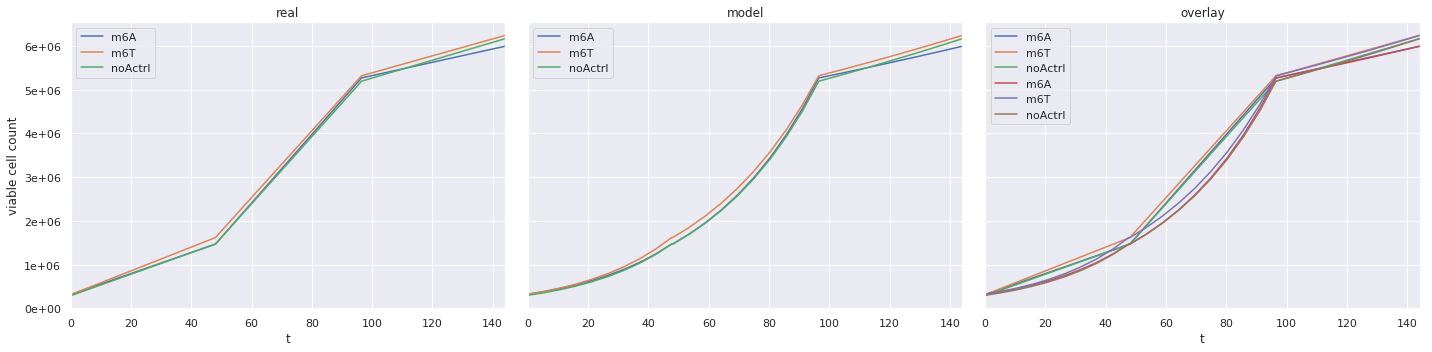

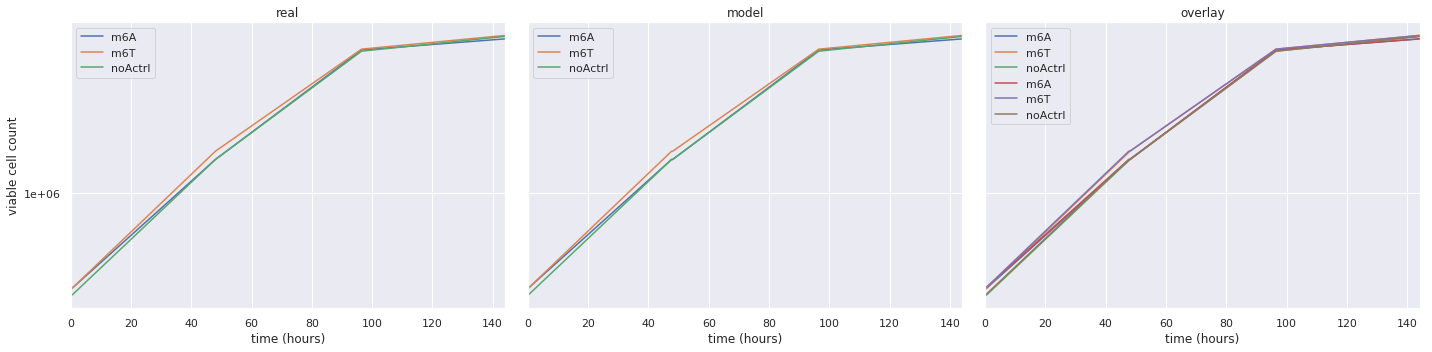

In [6]:
# ok lets replicate fig2a with my model and also with log scale on y axis
f, axs = plt.subplots(1,3, figsize=(20,5), sharex=True, sharey=True, tight_layout=True)
cell_count.plot(ax=axs[0], title='real')
model_cell_count.plot(ax=axs[1], title='model')
cell_count.plot(ax=axs[2], title="overlay")
model_cell_count.plot(ax=axs[2])
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
axs[0].set_ylabel("viable cell count")

f, axs = plt.subplots(1,3, figsize=(20,5), sharex=True, sharey=True, tight_layout=True)
cell_count.plot(ax=axs[0], logy=True, title='real')
model_cell_count.plot(ax=axs[1], logy=True, title='model')
cell_count.plot(ax=axs[2], logy=True, title="overlay")
model_cell_count.plot(ax=axs[2])
axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
axs[0].set_ylabel("viable cell count")
axs[0].set_xlabel("time (hours)")
axs[1].set_xlabel("time (hours)")
axs[2].set_xlabel("time (hours)")
plt.show()

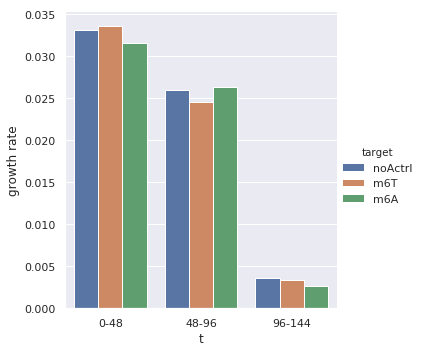

In [7]:
# lets take a look at those growth rates

gr_df = pd.DataFrame(growth_rates)
gr_df.index = ["0-48", "48-96", "96-144"]
gr_df = gr_df.unstack().reset_index()
gr_df.columns = ['target', 't', 'growth rate']
sns.catplot(x='t', hue='target', y='growth rate', data=gr_df, kind='bar', hue_order=['noActrl', 'm6T', 'm6A'])
plt.show()

In [8]:
# ok lets massage the titer data into a nicer format

titer_times = [int(x) for x in t[1:]]
titer = df[['m6Ttit', 'titm6A', 'titnoActrl']]
rows = []
for i, row in titer.iterrows():
    tp = row.dropna().loc[:,'X'].mean()
    tp = titer_times[np.argmin(abs(titer_times-tp))]
    rows.append({'t': tp, 'target': 'm6A', 'value': row['titm6A']['Y']})
    rows.append({'t': tp, 'target': 'm6T', 'value': row['m6Ttit']['Y']})
    rows.append({'t': tp, 'target': 'noActrl', 'value': row['titnoActrl']['Y']})
titer = pd.DataFrame(rows)

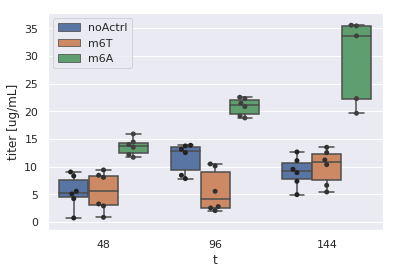

In [9]:
# and lets replicate their titer figure (2d)
ax = sns.boxplot(x='t', y='value', hue='target', hue_order=['noActrl', 'm6T', 'm6A'], data=titer)
sns.swarmplot(ax=ax, x='t', y='value', hue='target', dodge=True, hue_order=['noActrl', 'm6T', 'm6A'], color=".25", data=titer)
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[:3], labels[:3])
ax.set_ylabel("titer [ug/mL]")
plt.show()

In [10]:
# calculate Qp (pcd)
# I take the area under the cell growth curve and divide it by 24 to get days instead of hours
# Then I calculate the titer change in that period
# there are ~6 titer measurements per time point per target
# they are not matched, but maybe I can assume that they order the same way over time...

qps = []
for target in ['m6A', 'm6T', 'noActrl']:
    for tp in range(3):
        # integrate area under curve
        area = quad(lambda x: cell_count[target].values[tp]*np.e**(growth_rates[target][tp]*x), 0, 48)[0]/24
        # find titer increase
        ct = titer_times[tp]
        if tp == 0:
            qp_series = (titer.query("target==@target and t==@ct")['value']*1E6)/area
        else:
            pt = titer_times[tp-1]
            ctiter = (titer.query("target==@target and t==@ct")['value']*1E6).sort_values().values
            ptiter = (titer.query("target==@target and t==@pt")['value']*1E6).sort_values().values
            qp_series = (ctiter-ptiter)/area
        for qp in qp_series:
            qps.append({'t':ct, 'value':qp, 'target':target})
qps = pd.DataFrame(qps)

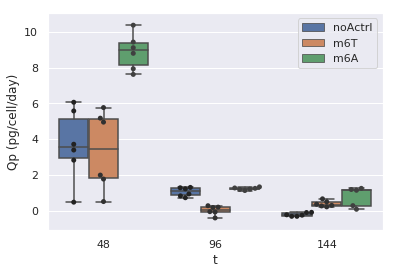

In [11]:
#lets make fig2c but also include qp for the 2 other periods measured
ax = sns.boxplot(x='t', y='value', hue='target', hue_order=['noActrl', 'm6T', 'm6A'], data=qps)
sns.swarmplot(ax=ax, x='t', y='value', hue='target', dodge=True, hue_order=['noActrl', 'm6T', 'm6A'], color=".25", data=qps)
handels, labels = ax.get_legend_handles_labels()
ax.legend(handels[:3], labels[:3])
ax.set_ylabel("Qp (pg/cell/day)")
plt.show()

In [12]:
# show the numbers
qps.groupby(['target', 't']).agg(['mean', 'std'])

value          
                 mean       std
target  t                      
m6A     48   8.872493  1.007002
        96   1.225146  0.070734
        144  0.783225  0.559356
m6T     48   3.355289  2.196974
        96   0.016273  0.252933
        144  0.378302  0.168326
noActrl 48   3.670075  2.017614
        96   1.043368  0.250748
        144 -0.221777  0.099502